# Testing HMC sampling from score function only

In [1]:
%pylab inline
from nsec.samplers import ScoreHamiltonianMonteCarlo
from nsec.datasets.swiss_roll import get_swiss_roll
import jax
import jax.numpy as jnp
import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax

Populating the interactive namespace from numpy and matplotlib


In [2]:
dist = get_swiss_roll(.5)

In [3]:
init_samples = dist.sample(10000, seed=jax.random.PRNGKey(0))

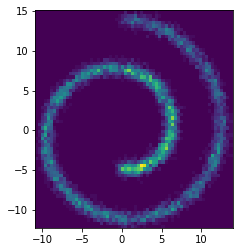

In [4]:
hist2d(init_samples[:,0], init_samples[:,1],64); gca().set_aspect('equal')

In [77]:
# Initialize the HMC transition kernel.
num_results = int(10e3)
num_burnin_steps = int(1e3)

kernel = ScoreHamiltonianMonteCarlo(
        target_score_fn=jax.grad(dist.log_prob),
        num_leapfrog_steps=10,
        num_delta_logp_steps=16,
        step_size=0.1)

In [78]:
samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=init_samples[1],
      kernel=kernel,
      trace_fn=lambda _, pkr: pkr.is_accepted, 
      seed=jax.random.PRNGKey(1))

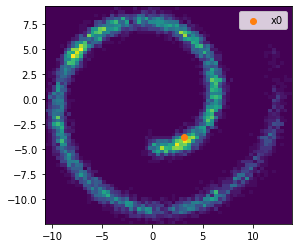

In [79]:
hist2d(samples[is_accepted,0], samples[is_accepted,1],64); gca().set_aspect('equal')
scatter(init_samples[1,0], init_samples[1,1], label='x0', color='C1')
legend()

In [80]:
# Same thing with proper HMC
kernel = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=dist.log_prob,
        num_leapfrog_steps=10,
        step_size=0.1)

In [81]:
samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=init_samples[1],
      kernel=kernel,
      trace_fn=lambda _, pkr: pkr.is_accepted, 
      seed=jax.random.PRNGKey(1))

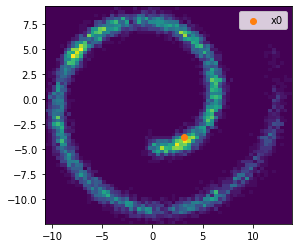

In [82]:
hist2d(samples[is_accepted,0], samples[is_accepted,1],64); gca().set_aspect('equal')
scatter(init_samples[1,0], init_samples[1,1], label='x0', color='C1')
legend()

In [129]:
# Let's try to learn that distribution
import numpy as onp
import haiku as hk
from jax.experimental import optix
from nsec.models.dae.ardae import ARDAE
from functools import partial

In [130]:
def forward(x, sigma, is_training=False):
    denoiser = ARDAE(is_training=is_training)
    return denoiser(x, sigma)

model_train = hk.transform_with_state(partial(forward, is_training=True))

In [183]:
batch_size = 512
delta = 0.5
rng_key = jax.random.PRNGKey(seed=0)

def get_batch(rng_key):
    y = dist.sample(batch_size, seed=rng_key)
    u = onp.random.randn(batch_size, 2)
    s = delta * onp.random.randn(batch_size, 1)
    x = y + s * u
    # x is a noisy sample, y is a sample from the distribution
    # u is the random normal noise realisation
    return {'x':x, 'y':y, 'u':u, 's':s}

In [184]:
optimizer = optix.adam(1e-3)
rng_seq = hk.PRNGSequence(42)

In [185]:
@jax.jit
def loss_fn(params, state, rng_key, batch):
    res, state = model_train.apply(params,  state, rng_key, 
                                   batch['x'], batch['s'])
    loss = jnp.mean((batch['u'] + batch['s'] * res)**2)
    return loss, state

In [186]:
@jax.jit
def update(params, state, rng_key, opt_state, batch):
    (loss, state), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, state, rng_key, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optix.apply_updates(params, updates)
    return loss, new_params, state, new_opt_state

In [187]:
params, state = model_train.init(next(rng_seq), 
                                 jnp.zeros((1, 2)), 
                                 jnp.ones((1, 1)))
opt_state = optimizer.init(params)
losses = []

In [188]:
for step in range(2000):
    batch = get_batch(next(rng_seq))
    loss, params, state, opt_state = update(params, state, next(rng_seq), opt_state, batch)
    losses.append(loss)
    if step%100==0:
        print(step, loss)

0 1.4878488
100 1.0153477
200 0.9157895
300 0.849964
400 0.9302703
500 0.8550159
600 0.9436257
700 0.88155913
800 0.8430685
900 0.8574153
1000 0.7877613
1100 0.79773474
1200 0.9061192
1300 0.9117352
1400 0.9063503
1500 0.84761804
1600 0.8609349
1700 0.8758292
1800 0.86526704
1900 0.87891066


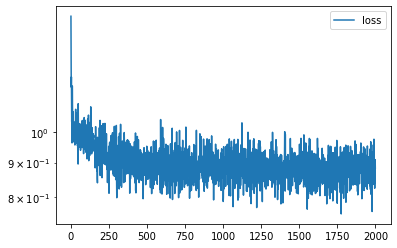

In [189]:
semilogy(np.array(losses[:]), label='loss')
legend()

In [190]:
X = np.arange(-12, 12, 0.5)
Y = np.arange(-12, 12, 0.5)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))

model = hk.transform_with_state(partial(forward, is_training=False))
score_fn = partial(model.apply, params, state, next(rng_seq))

In [191]:
res = score_fn(points, 0.0*jnp.ones((len(points),1)))[0]

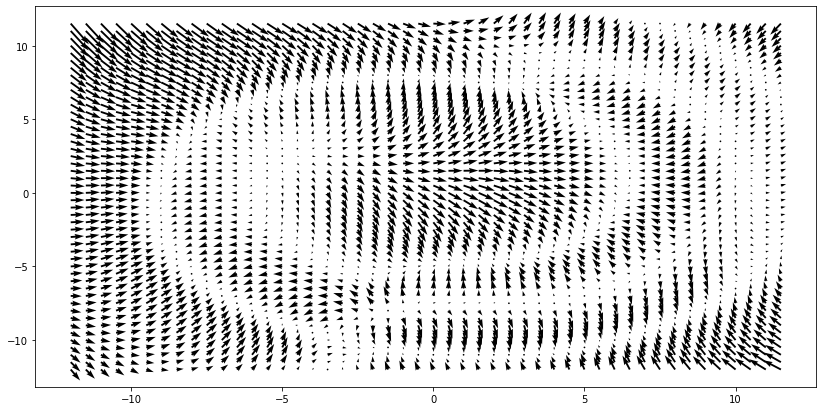

In [192]:
g = res.reshape([len(Y), len(X),2])
figure(figsize=(14,7))
quiver(X, Y, g[:,:,0], g[:,:,1])

In [193]:
def target_score_fn(x):
    x = x.reshape([1,2])
    return score_fn(x, 0.0*jnp.ones((len(x),1)))[0][0]

In [194]:
kernel = ScoreHamiltonianMonteCarlo(
        target_score_fn=target_score_fn,
        num_leapfrog_steps=10,
        num_delta_logp_steps=16,
        step_size=0.1)

In [195]:
samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=init_samples[1],
      kernel=kernel,
      trace_fn=lambda _, pkr: pkr.is_accepted, 
      seed=jax.random.PRNGKey(1))

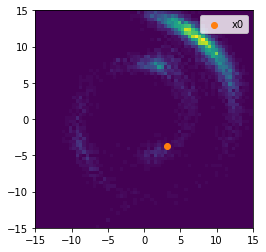

In [196]:
hist2d(samples[is_accepted,0], 
       samples[is_accepted,1],
       64, range=[[-15,15],[-15,15]]); gca().set_aspect('equal')

scatter(init_samples[1,0], init_samples[1,1], label='x0', color='C1')
legend()

In [148]:
# Now, same thing but with extra regularisation

In [169]:
from nsec.normalization import SNParamsTree as CustomSNParamsTree

def forward(x, sigma, is_training=False):
    denoiser = ARDAE(is_training=is_training)
    return denoiser(x, sigma)

model_train = hk.transform_with_state(partial(forward, is_training=True))

sn_fn = hk.transform_with_state(lambda x: CustomSNParamsTree(ignore_regex='[^?!.]*b$')(x))

In [170]:
optimizer = optix.adam(1e-3)
rng_seq = hk.PRNGSequence(42)

In [171]:
@jax.jit
def loss_fn(params, state, rng_key, batch):
    res, state = model_train.apply(params,  state, rng_key, 
                                   batch['x'], batch['s'])
    loss = jnp.mean((batch['u'] + batch['s'] * res)**2)
    return loss, state

In [172]:
@jax.jit
def update(params, state, sn_state, rng_key, opt_state, batch):
    (loss, state), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, state, rng_key, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optix.apply_updates(params, updates)
    
    new_params, new_sn_state = sn_fn.apply(None, sn_state, None, new_params)
    
    return loss, new_params, state, new_sn_state, new_opt_state

In [173]:
params, state = model_train.init(next(rng_seq), 
                                 jnp.zeros((1, 2)), 
                                 jnp.ones((1, 1)))
opt_state = optimizer.init(params)
_, sn_state = sn_fn.init(jax.random.PRNGKey(1), params)

losses = []

In [174]:
for step in range(2000):
    batch = get_batch(next(rng_seq))
    loss, params, state, sn_state, opt_state = update(params, state, sn_state, next(rng_seq), opt_state, batch)
    losses.append(loss)
    if step%100==0:
        print(step, loss)

0 1.4881493
100 1.0004711
200 0.964759
300 0.91756606
400 0.904888
500 0.9385742
600 0.8666869
700 0.8417999
800 0.91205055
900 0.93063724
1000 0.8412499
1100 0.86801434
1200 0.8694418
1300 0.87390834
1400 0.9125717
1500 0.8854516
1600 0.78280705
1700 0.93928444
1800 0.88182884
1900 0.9102773


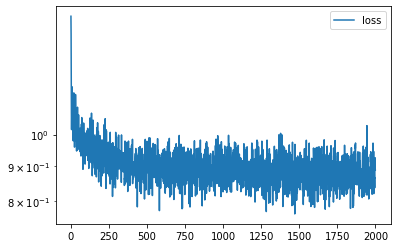

In [175]:
semilogy(np.array(losses[:]), label='loss')
legend()

In [176]:
X = np.arange(-15, 15, 0.5)
Y = np.arange(-15, 15, 0.5)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))

model = hk.transform_with_state(partial(forward, is_training=False))
score_fn = partial(model.apply, params, state, next(rng_seq))

In [177]:
res = score_fn(points, 0.0*jnp.ones((len(points),1)))[0]

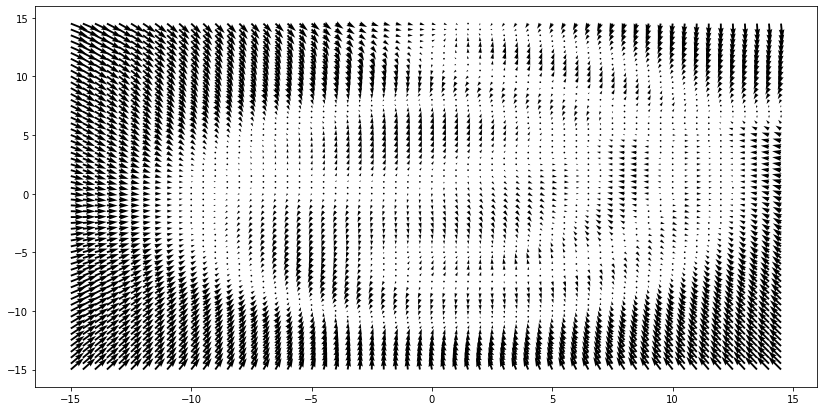

In [178]:
g = res.reshape([len(Y), len(X),2])
figure(figsize=(14,7))
quiver(X, Y, g[:,:,0], g[:,:,1])

In [179]:
def target_score_fn(x):
    x = x.reshape([1,2])
    return score_fn(x, 0.0*jnp.ones((len(x),1)))[0][0]

In [180]:
kernel = ScoreHamiltonianMonteCarlo(
        target_score_fn=target_score_fn,
        num_leapfrog_steps=10,
        num_delta_logp_steps=16,
        step_size=0.1)

In [181]:
samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=init_samples[1],
      kernel=kernel,
      trace_fn=lambda _, pkr: pkr.is_accepted, 
      seed=jax.random.PRNGKey(1))

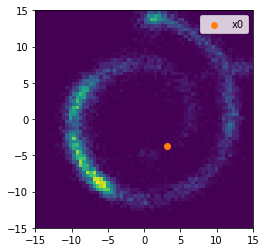

In [182]:
hist2d(samples[is_accepted,0], 
       samples[is_accepted,1],
       64, range=[[-15,15],[-15,15]]); gca().set_aspect('equal')

scatter(init_samples[1,0], init_samples[1,1], label='x0', color='C1')
legend()